In [85]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Flatten,
                                     Dense, Dropout, BatchNormalization)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

# Confirm GPU
print("GPU devices:", tf.config.list_physical_devices('GPU'))

# Global config
IMG_SIZE = 28
BATCH_SIZE = 16
EPOCHS = 10
LEARNING_RATE = 1e-3
tf.keras.backend.clear_session()

GPU devices: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [92]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths
base_path = 'II-V'
IMG_SIZE = 28
BATCH_SIZE = 16

# Augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range = 15 # degrees, play with 10–20 for visual difference
)


# No aug on val/test
val_datagen = ImageDataGenerator(rescale=1./255)

# Generators
train_gen = train_datagen.flow_from_directory(
    f"{base_path}/train",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=True
)

val_gen = val_datagen.flow_from_directory(
    f"{base_path}/val",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_gen = val_datagen.flow_from_directory(
    f"{base_path}/test",
    target_size=(IMG_SIZE, IMG_SIZE),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=1,
    shuffle=False
)


Found 1397 images belonging to 2 classes.
Found 398 images belonging to 2 classes.
Found 199 images belonging to 2 classes.


In [93]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

binary_model = Sequential([
    Conv2D(16, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

binary_model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])

# Train
binary_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10  # Adjust as needed
)


/home/skipper/tf-venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


/home/skipper/tf-venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


88/88 ━━━━━━━━━━━━━━━━━━━━ 7s 61ms/step - accuracy: 0.6498 - loss: 0.6267 - val_accuracy: 0.9774 - val_loss: 0.1710
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.8977 - loss: 0.3120 - val_accuracy: 0.9849 - val_loss: 0.0731
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.9176 - loss: 0.2177 - val_accuracy: 0.9799 - val_loss: 0.0654
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.9401 - loss: 0.1837 - val_accuracy: 0.9925 - val_loss: 0.0483
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9389 - loss: 0.1606 - val_accuracy: 0.9950 - val_loss: 0.0387
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.9423 - loss: 0.1406 - val_accuracy: 0.9950 - val_loss: 0.0333
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - accuracy: 0.9353 - loss: 0.1634 - val_accuracy: 0.9950 - val_loss: 0.0299
Epoch 8/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - accuracy: 0.9505 - loss: 0.1464 - val_accuracy: 0.9975 - val_loss: 0.

In [94]:
# Evaluate on test set
loss, acc = binary_model.evaluate(test_gen)
print(f"Test Accuracy: {acc*100:.4f}%")

199/199 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9969 - loss: 0.0202
Test Accuracy: 99.4975%


In [95]:
binary_model.save('2-5-11th.keras')

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


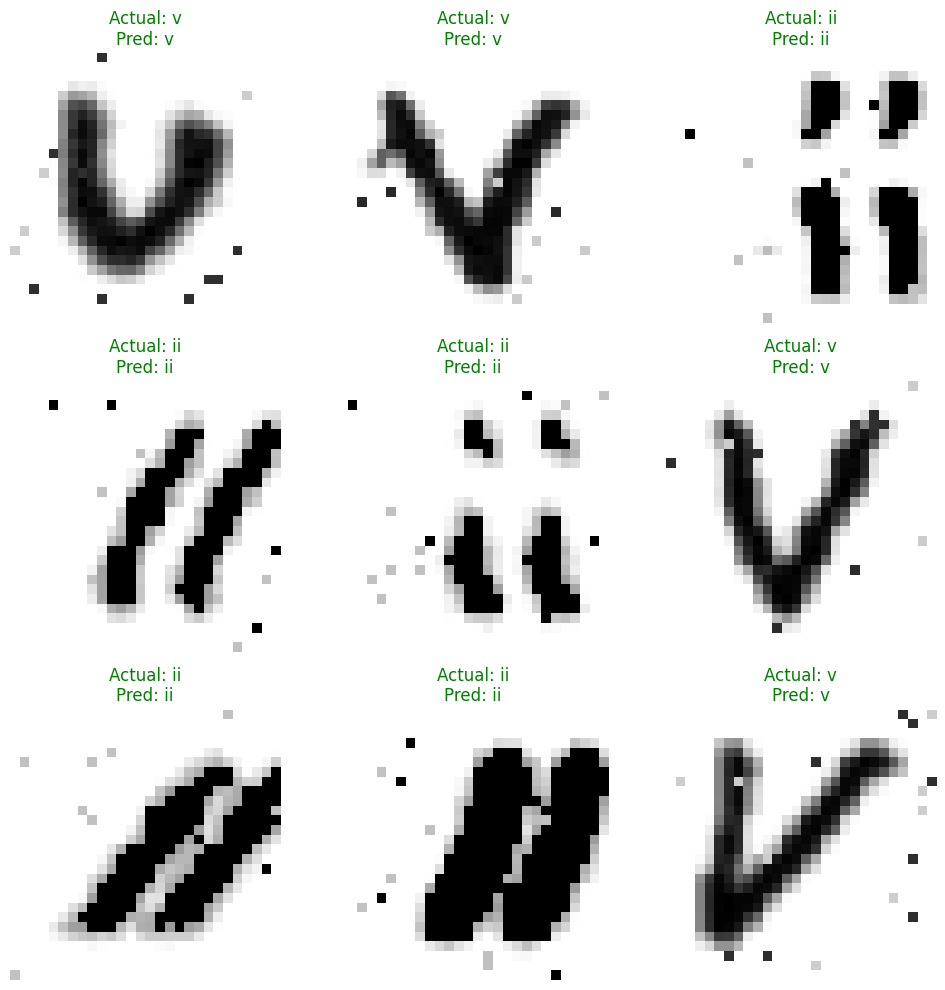

In [96]:
import random
import numpy as np
import matplotlib.pyplot as plt

# Load all test images and labels
x_test, y_test = next(test_gen)
for _ in range((test_gen.samples // test_gen.batch_size) - 1):
    x_batch, y_batch = next(test_gen)
    x_test = np.concatenate((x_test, x_batch))
    y_test = np.concatenate((y_test, y_batch))

# Predict on all test images
preds = binary_model.predict(x_test)
y_true = y_test.flatten()                  # Already one-hot like [1,0] or [0,1]? No. Binary = just [0] or [1]
y_pred = (preds.flatten() > 0.5).astype(int)

# Map class indices to label names
idx_to_class = {v: k for k, v in test_gen.class_indices.items()}

# Pick 9 random indices
random_indices = random.sample(range(len(x_test)), 9)

# Plot
plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    actual = idx_to_class[y_true[idx]]
    predicted = idx_to_class[y_pred[idx]]
    color = 'green' if actual == predicted else 'red'
    plt.title(f"Actual: {actual}\nPred: {predicted}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.show()